In [65]:
import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.oauth2.service_account import Credentials
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

In [ ]:
SERVICE_ACCOUNT_FILE = 'key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open('AI Summary Tagging').worksheet("negative_word")
data = sheet.get_all_records()

df = pd.DataFrame(data[1:], columns=data[0])

### Data Cleaning

In [55]:
df['Indikasi Kata Negative'] = [s.lower() for s in df['Indikasi Kata Negative'].astype(str).tolist()]

TEXT_COL = "Indikasi Kata Negative"

sentences = df[TEXT_COL].astype(str).tolist()

print("jumlah kalimat: ", len(sentences))
print("Contoh 5 kalimat pertama: ")

for s in sentences[:5]:
    print('-', s)

jumlah kalimat:  109
Contoh 5 kalimat pertama: 
- pinjaman gak bisa
- tidak bisa pengajuan kredit 
- limit paylater tidak bisa dipakai
- transaksi gagal
- kenapa gagal


### Model

In [56]:
# Semantic vector
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

embeddings = model.encode(sentences, show_progress_bar=True, convert_to_numpy=True)
embeddings.shape

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 384)

In [47]:
ex1 = sentences[1]
ex2 = sentences[2]

emb1 = model.encode(ex1, convert_to_numpy=True)
emb2 = model.encode(ex2, convert_to_numpy=True)

sim = util.cos_sim(emb1, emb2).item()
print("Cosine similarity:", round(sim, 3))

print(f"{ex1}\n{ex2}")

Cosine similarity: 0.558
tidak bisa pengajuan kredit 
limit paylater tidak bisa dipakai


In [ ]:
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.45,
    metric="cosine",
    linkage="average"
)

labels = clustering.fit_predict(embeddings)
len(set(labels)), labels[:20]

(33,
 array([ 0,  5,  5,  5,  1,  1,  1,  1,  1,  0,  5, 11, 24, 11,  0,  0,  0,
         1,  0,  6]))

In [61]:
df['cluster_id'] = labels
df.sort_values(['cluster_id'])

,Date,Validator,Ticket ID,AFI,Indikasi Kata Negative,cluster_id
56,2025-11-27,Azer,22376691,,akulaku bener2 sampah,0
40,2025-11-27,Aulia,21906956,AFI,akulaku gak berguna,0
93,2025-11-28,Aulia,20362026,AFI,apasi sekelas akulaku jelek sistemnya,0
90,2025-11-28,Aulia,20322021,AFI,saldo berkurang tapi di akulaku belum berhasil,0
31,2025-11-26,Reza,22387595,,tidak bisa melakukan pembayaran,1
...,...,...,...,...,...,...
66,2025-11-27,Neneng,21938278,AFI,tidak bisa membeli pulsa,22
38,2025-11-26,Reza,22387117,,sama sekali tidak membantu,23
12,2025-11-26,Azer,22288714,,belum nerima surat pelunasan,24
57,2025-11-27,Azer,22376864,,tidak muncul di riwayat dana cicil,24


In [90]:
df.to_csv('negative_word_clustered.csv', index=False)

### Visualize

In [84]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=20,
    learning_rate='auto',
    init='pca',
    max_iter=1000,
    verbose=1
)

tsne_coords = tsne.fit_transform(embeddings)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 109 samples in 0.001s...
[t-SNE] Computed neighbors for 109 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 109 / 109
[t-SNE] Mean sigma: 1.363865
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.984253
[t-SNE] KL divergence after 1000 iterations: 0.437453


In [85]:
df_tsne = df.copy().reset_index(drop=True)

assert tsne_coords.shape[0] == len(df_tsne), "Jumlah baris df dan embeddings harus sama"

df_tsne['tsne_x'] = tsne_coords[:, 0]
df_tsne['tsne_y'] = tsne_coords[:, 1]
df_tsne['cluster_id'] = labels

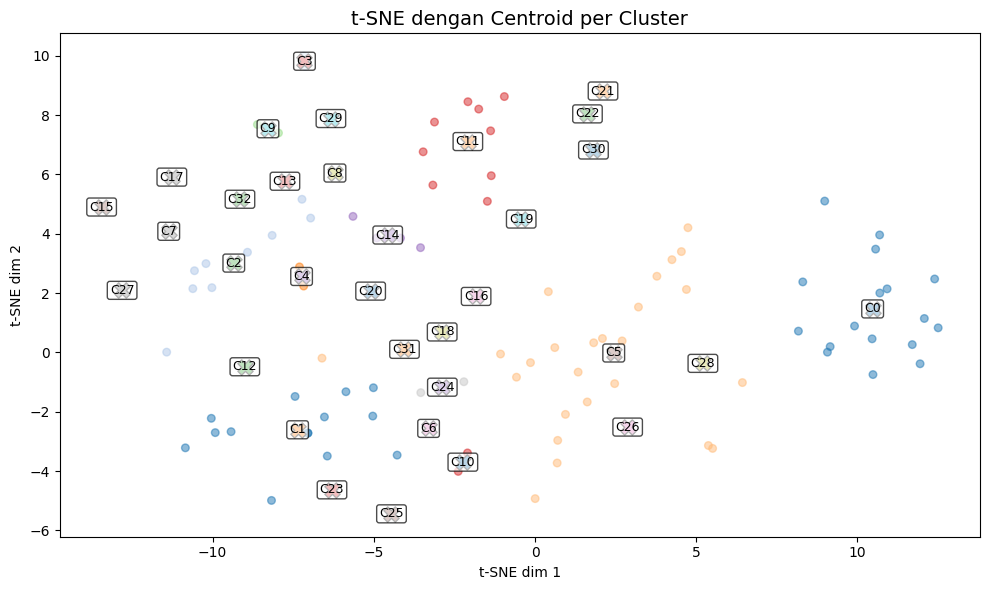

In [89]:
# ===== 5. Tambahkan titik rata-rata per cluster + 1 contoh kalimat =====

unique_clusters = np.unique(labels)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    df_tsne['tsne_x'],
    df_tsne['tsne_y'],
    c=df_tsne['cluster_id'],
    cmap='tab20',
    alpha=0.5,
    s=30
)

for cid in unique_clusters:
    sub = df_tsne[df_tsne['cluster_id'] == cid]
    cx = sub['tsne_x'].mean()
    cy = sub['tsne_y'].mean()
    
    # plot centroid
    plt.scatter(cx, cy, edgecolor='black', s=120, marker='X')
    plt.text(
        cx, cy,
        f"C{cid}",
        fontsize=9,
        ha='center',
        va='center',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
    )

plt.title("t-SNE dengan Centroid per Cluster", fontsize=14)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()
